In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, AutoRegressiveBaseModel,AutoRegressiveBaseModelWithCovariates
from pytorch_forecasting.metrics import MAE,RMSE
import os
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_forecasting.models.nn import LSTM
from typing import Dict
from sklearn.preprocessing import StandardScaler
import random

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
stream = pd.read_pickle(os.path.join('..','data','processed','stream_processed.pkl'),compression= 'zip')
meteo = pd.read_pickle(os.path.join('..','data','processed','meteo_processed.pkl'),compression = 'zip')
stream

measurement_location,Datum,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,15217908,15221009,15228008,15241006,15242304,15243001,15246000,15247002,15247501
0,2014-01-01,14.4,17.2,19.8,3.87,8.66,9.66,0.433,2.35,0.207,1.66,0.921,0.671,2.59,0.253,0.870,1.26,2.35,0.355,0.120
1,2014-01-02,14.4,17.0,19.3,3.78,8.52,9.46,0.435,2.51,0.204,1.62,0.909,0.664,2.57,0.253,0.870,1.23,2.32,0.361,0.131
2,2014-01-03,14.1,16.6,19.3,3.78,8.40,9.42,0.429,2.61,0.201,1.60,0.907,0.641,2.58,0.253,0.871,1.23,2.30,0.362,0.130
3,2014-01-04,14.2,16.6,19.3,3.84,8.57,9.50,0.445,2.49,0.214,1.64,0.935,0.642,2.60,0.256,0.929,1.26,2.44,0.382,0.127
4,2014-01-05,16.4,18.4,20.6,4.36,9.94,10.80,0.545,2.86,0.267,1.80,1.130,0.690,3.10,0.300,1.150,1.61,3.14,0.561,0.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2023-12-28,79.7,102.0,120.0,28.50,46.20,57.10,1.900,17.30,0.721,10.30,6.070,3.920,12.20,0.786,3.270,9.05,12.50,2.020,0.741
3649,2023-12-29,71.4,82.5,97.7,26.00,41.90,51.30,1.710,15.60,0.801,9.85,5.480,3.470,10.90,0.653,2.890,7.23,9.97,1.750,0.619
3650,2023-12-30,64.0,71.4,86.3,24.40,38.60,46.90,1.530,14.70,0.835,9.40,4.900,3.100,9.77,0.557,2.550,5.92,8.54,1.470,0.514
3651,2023-12-31,59.1,63.0,77.3,22.20,35.30,42.50,1.410,13.10,0.669,8.83,4.480,2.670,8.92,0.492,2.330,5.40,7.66,1.290,0.458


In [ ]:
stream[list(stream.columns[1:])] = stream[list(stream.columns[1:])].rolling(window=3).mean()

In [ ]:
def mean_meteo(df : pd.DataFrame,meteo : str):
    in_df = df.copy()[[col for col in df.columns if meteo in col]]
    return in_df.mean(axis = 1)
    

In [ ]:

meteo_vars = ['t2m','tp','ssr','d2m','sp']

for var in meteo_vars:
    meteo[f"mean_{var}"] = mean_meteo(meteo,var)

tp_to_drop = [col for col in meteo.columns if 'tp_' in col]
d2m_to_drop = [col for col in meteo.columns if 'd2m_' in col]
ssr_to_drop = [col for col in meteo.columns if 'ssr_' in col]
t2m_to_drop = [col for col in meteo.columns if 't2m_' in col]
sp_tp_drop = [col for col in meteo.columns if 'sp_' in col]
cols_to_drop = tp_to_drop + d2m_to_drop + ssr_to_drop + t2m_to_drop + sp_tp_drop
meteo = meteo.drop(columns = cols_to_drop)
meteo[['mean_t2m','mean_tp','mean_ssr','mean_d2m','mean_sp']] = meteo[['mean_t2m','mean_tp','mean_ssr','mean_d2m','mean_sp']].rolling(3).mean()
meteo = meteo.dropna()
meteo.head()

In [5]:
stream = stream.iloc[:3652]
meteo = meteo.drop(columns = 'date')
data = stream.join(meteo).drop(columns = 'Datum').dropna()
data['groups'] = 0
data['date'] = data.index
data

,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,...,tp_8600,tp_8711,tp_8712,tp_8720,tp_8731,tp_8732,tp_8800,tp_8900,groups,date
2,14.1,16.6,19.3,3.78,8.40,9.42,0.429,2.61,0.201,1.60,...,6.833090e-06,0.000007,6.630144e-06,3.969168e-06,6.355495e-06,3.869216e-06,6.033745e-06,7.608540e-06,0,2
3,14.2,16.6,19.3,3.84,8.57,9.50,0.445,2.49,0.214,1.64,...,9.848191e-07,0.000001,9.627160e-07,3.152130e-07,6.812810e-07,1.552123e-07,2.603002e-07,6.997454e-07,0,3
4,16.4,18.4,20.6,4.36,9.94,10.80,0.545,2.86,0.267,1.80,...,2.306176e-04,0.000231,2.262798e-04,1.507445e-04,2.086118e-04,1.238402e-04,1.149645e-04,2.004822e-04,0,4
5,18.3,21.4,24.4,4.38,10.70,11.50,0.524,2.87,0.237,1.78,...,1.084148e-04,0.000105,1.079762e-04,1.110781e-04,1.135130e-04,1.155993e-04,1.087480e-04,1.086862e-04,0,5
6,15.5,19.6,23.9,4.04,9.61,10.40,0.477,2.60,0.219,1.67,...,2.335611e-05,0.000031,2.357872e-05,8.976913e-06,1.149020e-05,2.702179e-06,1.805063e-06,9.742068e-06,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,95.2,138.0,161.0,32.60,54.00,67.80,2.210,21.50,0.993,9.91,...,9.478747e-05,0.000079,8.868271e-05,3.403158e-05,9.855289e-05,3.830239e-05,5.742425e-05,1.013266e-04,0,3647
3648,79.7,102.0,120.0,28.50,46.20,57.10,1.900,17.30,0.721,10.30,...,1.199765e-05,0.000010,1.123335e-05,4.253323e-06,1.239131e-05,4.485424e-06,8.188290e-06,1.386781e-05,0,3648
3649,71.4,82.5,97.7,26.00,41.90,51.30,1.710,15.60,0.801,9.85,...,7.186941e-06,0.000008,7.407126e-06,8.299928e-06,6.351444e-06,6.934943e-06,4.598457e-06,5.399495e-06,0,3649
3650,64.0,71.4,86.3,24.40,38.60,46.90,1.530,14.70,0.835,9.40,...,4.738118e-05,0.000046,4.672316e-05,4.066719e-05,4.754517e-05,4.259339e-05,4.157456e-05,4.536385e-05,0,3650


In [7]:
max_pred_len = 3
enc_len = 364
# training_cutoff = int(data["date"].max()*0.7) - max_pred_len
val_cutoff = int(data["date"].max()*0.15) - max_pred_len
test_cutoff = int(data["date"].max()*0.3)- max_pred_len

training = TimeSeriesDataSet(
    data= data.iloc[test_cutoff:],
    target='15207507',#'15207507'
    group_ids=['groups'],#groups
    time_idx='date',#date
    min_prediction_idx=test_cutoff,
    max_encoder_length=enc_len,
    min_encoder_length=enc_len,
    min_prediction_length=max_pred_len,
    max_prediction_length=max_pred_len,
    time_varying_unknown_reals=['15207507'],
    time_varying_known_reals=['mean_t2m','mean_tp','mean_ssr','mean_d2m','mean_sp']#data.columns[20:-1].values.tolist(),
)

validation = TimeSeriesDataSet.from_dataset(training,data.iloc[: val_cutoff],min_prediction_idx=0,stop_randomization=True)

train_dataloader = training.to_dataloader(train=True, batch_size=128, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=32, num_workers=2)


In [14]:

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.001,
    hidden_size=64,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.2,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,  # set to <= hidden_size
    loss=MAE(),
    optimizer="adam",
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience = 7,
    reduce_on_plateau_min_lr = 0.00001,
    weight_decay = 0.001
    )

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [55]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    max_epochs=40,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [56]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 12.3 K
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.0 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.0 M 
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 135/135 [03:11<00:00,  0.71it/s, v_num=59, train_loss_step=7.230, val_loss=9.000, train_loss_epoch=8.530]

Metric val_loss improved. New best score: 9.003


Epoch 1: 100%|██████████| 135/135 [03:14<00:00,  0.69it/s, v_num=59, train_loss_step=4.290, val_loss=5.860, train_loss_epoch=5.590]

Metric val_loss improved by 3.144 >= min_delta = 0.0. New best score: 5.859


Epoch 4: 100%|██████████| 135/135 [03:17<00:00,  0.68it/s, v_num=59, train_loss_step=4.210, val_loss=7.620, train_loss_epoch=4.140]

Monitored metric val_loss did not improve in the last 3 records. Best score: 5.859. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 135/135 [03:18<00:00,  0.68it/s, v_num=59, train_loss_step=4.210, val_loss=7.620, train_loss_epoch=4.140]


In [57]:
best_model_path = trainer.checkpoint_callback.best_model_path
#os.path.join(,'lightning_logs','version_9','checkpoints','epoch=9-step=680.ckpt')
best_lstm = streamflow_tft.load_from_checkpoint(best_model_path)#os.path.join(best_model_path,'lightning_logs','version_24','checkpoints','epoch=19-step=680.ckpt'))

In [58]:
test = TimeSeriesDataSet.from_dataset(training,data.iloc[val_cutoff:],min_prediction_idx = val_cutoff+365,stop_randomization=True)
test_dataloader = test.to_dataloader(train=False, batch_size=2, num_workers=2)
len(test)

184

In [59]:
predictions = best_lstm.predict(test_dataloader,return_y=True,trainer_kwargs=dict(accelerator="cpu"))


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [60]:
def kge(inputs,targets):
    r = torch.corrcoef(torch.stack((inputs.squeeze(),targets)))[0][1]
    alpha = inputs.std()/targets.std()
    beta = inputs.mean()/targets.mean()
    kge = torch.sqrt(torch.square(r-1) + torch.square(alpha-1) + torch.square(beta-1))
    return 1 - kge

In [61]:
kge(torch.tensor(stream['15207507_smooth'].iloc[-184:].values),predictions.output[:,max_pred_len-1])#[:,max_pred_len-1]

tensor(0.8570, dtype=torch.float64)

In [19]:
predictions.output.shape

torch.Size([184, 1])

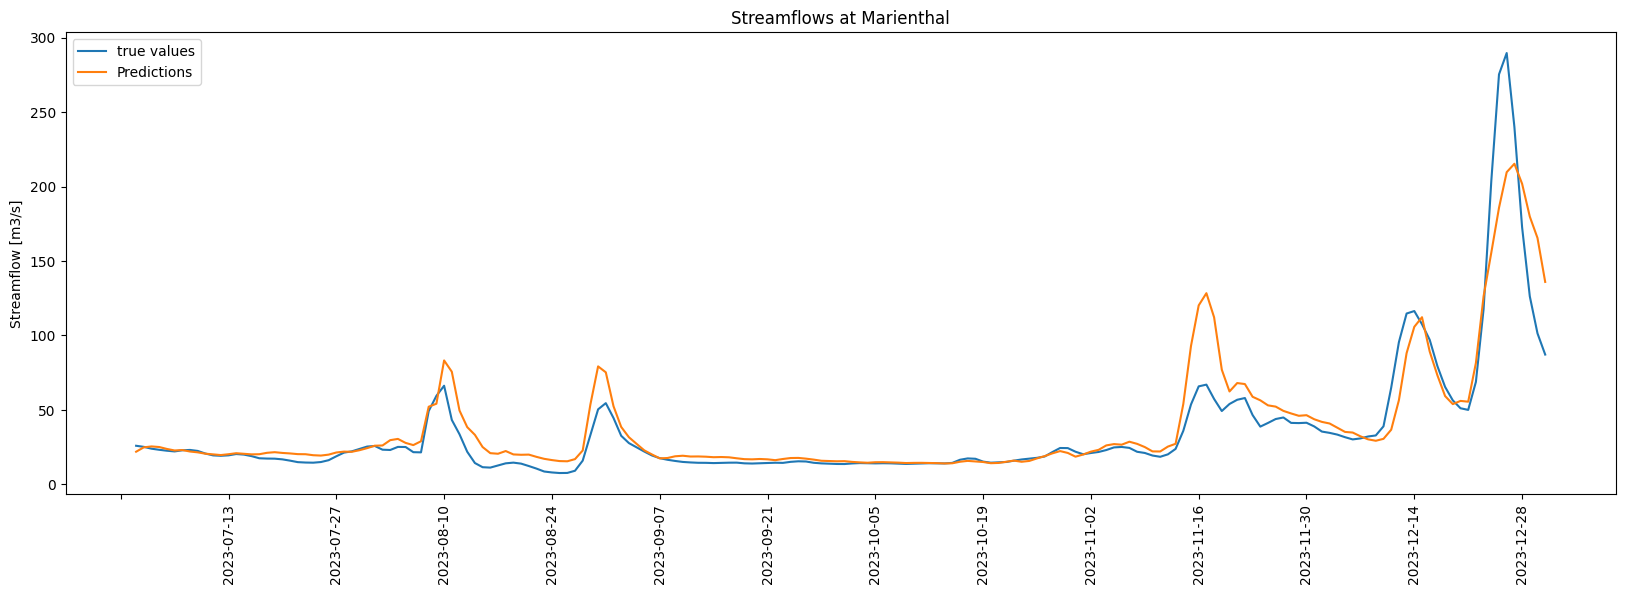

In [62]:
import matplotlib.dates as mdates


stream_plot = stream.set_index('Datum')
predictions_np = predictions.output[:,max_pred_len-1].numpy()#[:,max_pred_len-1]
# true_values_np = predictions.y[0].view(-1, 1).squeeze().numpy()

# Plotting

plt.figure(figsize=(20, 6))


plt.plot(stream_plot.index[-184:],stream_plot['15207507_smooth'].iloc[-184:].values,  label = 'true values')

plt.plot(predictions_np, label='Predictions')


plt.ylabel('Streamflow [m3/s]')
plt.title('Streamflows at Marienthal')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.legend()
plt.xticks(rotation=90)
plt.show()